In [3]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import root_pandas as rpd
from root_pandas import read_root

mpl.rcParams['figure.figsize'] = 6.2,3.5
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['legend.fontsize']= 15

In [4]:
def getRatio(df_A,df_D,df_trigger_A,df_trigger_D, variable='z_asso',trig_cut = 'z>0.5', pair_cut='',minz=0.06,maxz=0.5,nbins=16):
    #get number of pions with z>0.5
    norm_A = df_trigger_A.query(trig_cut).shape[0]
    norm_D = df_trigger_D.query(trig_cut).shape[0]
    y_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    y_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    x_conditional = (x_conditional[1:] + x_conditional[:-1])/2.0
    err_A = np.true_divide(np.sqrt(y_A),y_A)
    err_D = np.true_divide(np.sqrt(y_D),y_D)
    y_A = np.true_divide(y_A,norm_A)
    y_D = np.true_divide(y_D,norm_D)
    ratio_conditional = np.true_divide(y_A,y_D)
    error_conditional = np.multiply(ratio_conditional, np.sqrt(np.power(err_A,2.0) + np.power(err_D,2.0)))
    
    return ratio_conditional,error_conditional,x_conditional

In [5]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe
def applyCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/5.014', inplace=True)
    dataframe.eval('E = z*Nu', inplace=True)
    dataframe.eval('P = sqrt(E*E-0.140*0.140)', inplace=True)
    
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'W>2.0', 'W>2.0 :')
    #dataframe = applyCut(dataframe, 'Nu>3.5', 'Nu>3.5 :')

    dataframe = applyCut(dataframe, 'z>0.5', 'z>0.5 :')
    dataframe = applyCut(dataframe, 'P <2.5 ', 'P<2.5 ')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe

def applyCutsPair(fullDataframe,name='default'):
    print 'Starting election on dipion variables'
    dataframe = fullDataframe
    dataframe.eval('z_tot = z+z_asso', inplace=True)
    dataframe.eval('E_asso = z_asso*Nu', inplace=True)
    dataframe.eval('P_asso = sqrt(E_asso*E_asso-0.140*0.140)', inplace=True)
    
    #dataframe = applyCut(dataframe, 'pid*pid_asso<0', 'Opposite sign pairs')
    dataframe = applyCut(dataframe, 'pid>0 and pid_asso<0', 'Opposite sign pairs')
    dataframe = applyCut(dataframe, 'P_asso>0.100', 'P_asso > 100 MeV')
    dataframe = applyCut(dataframe, 'P_asso<2.5', 'P_asso <2.5 GeV')
    

    return dataframe

def printPairBreakdown(dataframe):
    
    print 'All pairs ', dataframe.shape[0]
    print 'Pairs with Leading pi+', dataframe.query('pid==211').shape[0]
    print 'Pairs with Leading pi-', dataframe.query('pid==-211').shape[0]
    print 'Pairs with Sub-Leading pi+', dataframe.query('pid_asso==211').shape[0]
    print 'Pairs with Sub-Leading pi-', dataframe.query('pid_asso==-211').shape[0]
    print 'pi+ pi+ pairs',dataframe.query('pid==211 and pid_asso==211').shape[0]
    print 'pi- pi- pairs',dataframe.query('pid==-211 and pid_asso==-211').shape[0]
    print 'pi+ pi- pairs',dataframe.query('pid==211 and pid_asso==-211').shape[0]
    print 'pi- pi+ pairs',dataframe.query('pid==-211 and pid_asso==211').shape[0]
    print '//////////////////////////////////////////////////////'
    return 


## Get data from Ntuples to dataframes

In [6]:
#this needs to be read in chunks otherwise it uses all memory. (from https://github.com/scikit-hep/root_pandas)
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df])
    
    print dataframe.shape[0]
    return dataframe
    

## Get data

In [7]:
df = {}
df_trigger = {}

for target in ['C','Fe','Pb']:
    print 'Getting dataframes from target %s'%target
    df[target]=getdatainChunks('Pairs_%s.root'%target, target)
    df['D_%s'%target]= getdatainChunks('Pairs_%s.root'%target, 'D_%s'%target)  
    print 'Get trigger dataframes from target %s'%target
    df_trigger['%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, 'D_%s_trigger'%target)

Getting dataframes from target C
294942
395135
Get trigger dataframes from target C
1218503
1599452
Getting dataframes from target Fe
401683
715969
Get trigger dataframes from target Fe
1774824
2886931
Getting dataframes from target Pb
110447
574977
Get trigger dataframes from target Pb
527766
2349115


## GiBUU 

In [8]:
for target in ['D','C','Fe','Pb']:#,'Fe','C']:
    #GiBUU
    df['GiBUU_%s'%target]= getdatainChunks('GiBUU_Pairs_%s.root'%target, target)
    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('GiBUU_Pairs_%s.root'%target, '%s_trigger'%target)

60240
96021
150219
238611
102825
166850
89141
145708


## Combine the deuterium datasets 

In [9]:
df['D'] = pd.concat([df['D_Pb'],df['D_Fe'],df['D_C']]) #simply combine the deuterium results for all targets
df_trigger['D_trigger'] = pd.concat([df_trigger['D_Pb_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_C_trigger']]) #simply combine the deuterium results for all targets



## Apply selection for pair ntuples

In [10]:
#dataframees with pairs
for key in df.keys():
    print key
    df[key] = applyCuts(df[key])
    #printPairBreakdown(df[key])
    df[key] = applyCutsPair(df[key])
    print ' '
    


C
Entries before cut  294942
Q2>1.0 : 294942  (100.00  %)
z>0.5 : 133831  (45.38  %)
P<2.5  116838  (87.30  %)
inelasticity < 0.85 113394  (97.05  %)
Starting election on dipion variables
Opposite sign pairs 58764  (51.82  %)
P_asso > 100 MeV 58762  (100.00  %)
P_asso <2.5 GeV 58705  (99.90  %)
 
D
Entries before cut  1686081
Q2>1.0 : 1686081  (100.00  %)
z>0.5 : 802624  (47.60  %)
P<2.5  696928  (86.83  %)
inelasticity < 0.85 680119  (97.59  %)
Starting election on dipion variables
Opposite sign pairs 378452  (55.64  %)
P_asso > 100 MeV 378452  (100.00  %)
P_asso <2.5 GeV 378144  (99.92  %)
 
GiBUU_C
Entries before cut  150219
Q2>1.0 : 150219  (100.00  %)
z>0.5 : 150219  (100.00  %)
P<2.5  99901  (66.50  %)
inelasticity < 0.85 99901  (100.00  %)
Starting election on dipion variables
Opposite sign pairs 49422  (49.47  %)
P_asso > 100 MeV 48028  (97.18  %)
P_asso <2.5 GeV 48028  (100.00  %)
 
GiBUU_Fe
Entries before cut  102825
Q2>1.0 : 102825  (100.00  %)
z>0.5 : 102825  (100.00  %)
P<

## Apply cuts for trigger dataframes

In [11]:
for key in df_trigger.keys():
    print key
    df_trigger[key] = applyCuts(df_trigger[key])
    print ' ' 

D_C_trigger
Entries before cut  1599452
Q2>1.0 : 1599452  (100.00  %)
z>0.5 : 931192  (58.22  %)
P<2.5  751869  (80.74  %)
inelasticity < 0.85 737719  (98.12  %)
 
D_trigger
Entries before cut  6835498
Q2>1.0 : 6835498  (100.00  %)
z>0.5 : 3984109  (58.29  %)
P<2.5  3217923  (80.77  %)
inelasticity < 0.85 3159174  (98.17  %)
 
D_Pb_trigger
Entries before cut  2349115
Q2>1.0 : 2349115  (100.00  %)
z>0.5 : 1370279  (58.33  %)
P<2.5  1107388  (80.81  %)
inelasticity < 0.85 1086970  (98.16  %)
 
Pb_trigger
Entries before cut  527766
Q2>1.0 : 527766  (100.00  %)
z>0.5 : 291255  (55.19  %)
P<2.5  239158  (82.11  %)
inelasticity < 0.85 233659  (97.70  %)
 
GiBUU_C_trigger
Entries before cut  238611
Q2>1.0 : 238611  (100.00  %)
z>0.5 : 238611  (100.00  %)
P<2.5  125555  (52.62  %)
inelasticity < 0.85 125555  (100.00  %)
 
GiBUU_Fe_trigger
Entries before cut  166850
Q2>1.0 : 166850  (100.00  %)
z>0.5 : 166850  (100.00  %)
P<2.5  88694  (53.16  %)
inelasticity < 0.85 88694  (100.00  %)
 
Fe_trig

## Get R_2h for various selections 

In [12]:
#nominal (no selection)
r_C, err_C,x   = getRatio(df['C'], df['D_C'], df_trigger['C_trigger'], df_trigger['D_C_trigger'])
r_Fe, err_Fe,x = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'])
r_Pb, err_Pb,x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'])

## R_2h for MC

In [13]:
rMC_C, rMC_err_C,x = getRatio(df['GiBUU_C'],df['GiBUU_D'],df_trigger['GiBUU_C_trigger'],df_trigger['GiBUU_D_trigger'])
rMC_Fe, rMC_err_Fe,x = getRatio(df['GiBUU_Fe'],df['GiBUU_D'],df_trigger['GiBUU_Fe_trigger'],df_trigger['GiBUU_D_trigger'])
rMC_Pb, rMC_err_Pb,x = getRatio(df['GiBUU_Pb'],df['GiBUU_D'],df_trigger['GiBUU_Pb_trigger'],df_trigger['GiBUU_D_trigger'])

## R_2h data from HERMES and Neutrino buble-chamber experiment

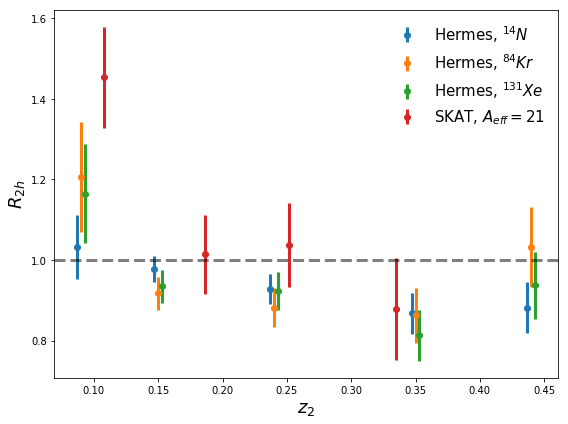

In [14]:
#hermes data:
hermes_y = {}
hermes_ystat = {}
hermes_ysyst = {}
hermes_ytotal = {}

#DATA FROM SELECTIO1 OF http://www-hermes.desy.de/notes/pub/publications.html
hermes_x = {}
hermes_x['Kr'] = [0.09,0.15,0.24,0.35,0.44]
hermes_x['N'] = np.subtract(hermes_x['Kr'],0.003)
hermes_x['Xe'] = np.subtract(hermes_x['Kr'],-0.003)

#nitrogen, atomic number 7
hermes_y['N']     = [1.0324, 0.9781,0.9293,0.8678,0.8822]
hermes_ystat['N'] = [0.0767,0.0268,0.0323,0.0478,0.0601]
hermes_ysyst['N'] = [0.0206,0.0196,0.0186,0.0174,0.0176]
hermes_ytotal['N'] = np.sqrt(np.power(hermes_ystat['N'],2.0)+np.power(hermes_ysyst['N'],2.0))

#krypton, atomic number 36
hermes_y['Kr'] = [1.2072,0.9180,0.8822,0.8631,1.0314]
hermes_ystat['Kr'] = [0.1342,0.0366,0.0452,0.0661,0.0972]
hermes_ysyst['Kr'] =[0.0241,0.0184,0.0176,0.0173,0.0206]
hermes_ytotal['Kr'] = np.sqrt(np.power(hermes_ystat['Kr'],2.0)+np.power(hermes_ysyst['Kr'],2.0))

hermes_y['Xe'] = [1.1648,0.9345,0.9242,0.8128,0.9373]
hermes_ystat['Xe'] = [0.1205,0.0359,0.0433,0.0614,0.0808]
hermes_ysyst['Xe'] = [0.0233,0.0187,0.0185,0.0163,0.0187]
hermes_ytotal['Xe'] = np.sqrt(np.power(hermes_ystat['Xe'],2.0)+np.power(hermes_ysyst['Xe'],2.0))


neutrino_x = [0.10763636363636367, 0.18618181818181817,0.25163636363636366,0.3345454545454546]
neutrino_y = [1.4535664335664338, 1.0148378893833438,  1.0373426573426574, 0.8784361093452003]
neutrino_yerror =[1.5794405594405596, 1.112739987285442, 1.1422377622377624,1.004310235219326]
neutrino_yerror = np.subtract(neutrino_yerror,neutrino_y)

fig = plt.figure(figsize=(8,6))



plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],label='Hermes, $^{14}N$',fmt='o')
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],label='Hermes, $^{84}Kr$',fmt='o')
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],label='Hermes, $^{131}Xe$',fmt='o')
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,label='SKAT, $A_{eff}=21$',fmt='o')
plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)

plt.tight_layout()
plt.legend(frameon=False)
plt.savefig('PreviousData.png')
plt.show()

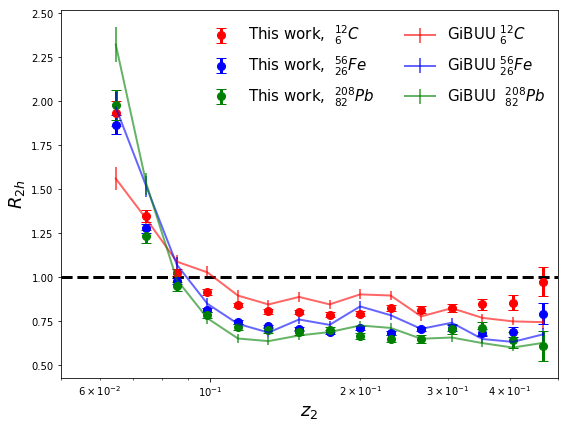

In [15]:
fig = plt.figure(figsize=(8,6))

plt.errorbar(x,r_C,yerr=err_C,label='This work,  $^{12}_{6}C$',fmt='ro',ms=8,lw=3,capsize=5)
plt.errorbar(x,r_Fe,yerr=err_Fe,label='This work,  $^{56}_{26}Fe$',fmt='bo',ms=8,lw=3,capsize=5)
plt.errorbar(x,r_Pb,yerr=err_Pb,label='This work,  $^{208}_{82}Pb$',fmt='go',ms=8,lw=3,capsize=5)

#Other data
#plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',label='HERMES, $^{14}_{7}N$',fillstyle=None,ms=8,capsize=5)
#plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',label='HERMES, $^{84}_{36}Kr$',fillstyle=None,ms=8,capsize=5)
#plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',label='HERMES, $^{131}_{54}Xe$',fillstyle=None,ms=8,capsize=5)
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)


plt.errorbar(x,rMC_C,yerr=rMC_err_C,label='GiBUU $^{12}_{6}C$',color='red',ms=8,lw=2,alpha=0.6)
plt.errorbar(x,rMC_Fe,yerr=rMC_err_Fe,label='GiBUU $^{56}_{26}Fe$',color='blue',ms=8,lw=2,alpha=0.6)
plt.errorbar(x,rMC_Pb,yerr=rMC_err_Pb,label='GiBUU  $^{208}_{82}Pb$',color='green',ms=8,lw=2,alpha=0.6)


plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.ylim([0.5,1.5])
#plt.xlim([0.00,0.5])


plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=2)

plt.tight_layout()
plt.savefig('ComparisonWithHermes_Linear.png')


plt.xlim([0.05,0.5])

plt.xscale('log')
plt.savefig('ComparisonWithHermes_Log.png')

plt.show()

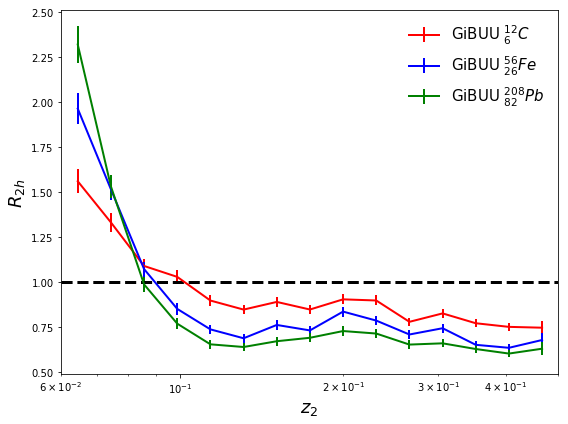

In [16]:
fig = plt.figure(figsize=(8,6))


r, err,x = getRatio(df['GiBUU_C'],df['GiBUU_D'],df_trigger['GiBUU_C_trigger'],df_trigger['GiBUU_D_trigger'])
plt.errorbar(x,r,yerr=err,label='GiBUU $^{12}_{6}C$',color='red',ms=8,lw=2)

r, err,x = getRatio(df['GiBUU_Fe'],df['GiBUU_D'],df_trigger['GiBUU_Fe_trigger'],df_trigger['GiBUU_D_trigger'])
plt.errorbar(x,r,yerr=err,label='GiBUU $^{56}_{26}Fe$',color='blue',ms=8,lw=2)

r, err,x = getRatio(df['GiBUU_Pb'],df['GiBUU_D'],df_trigger['GiBUU_Pb_trigger'],df_trigger['GiBUU_D_trigger'])
plt.errorbar(x,r,yerr=err,label='GiBUU $^{208}_{82}Pb$',color='green',ms=8,lw=2)

plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

plt.xlim([0.06,0.5])


plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


x = [0.0746875, 0.1040625, 0.1334375, 0.1628125, 0.1921875, 0.2215625, 0.2509375,
 0.2803125, 0.3096875, 0.3390625, 0.3684375, 0.3978125, 0.4271875, 0.4565625,
 0.4859375, 0.5153125, 0.5446875, 0.5740625, 0.6034375, 0.6328125, 0.6621875,
 0.6915625, 0.7209375, 0.7503125, 0.7796875, 0.8090625, 0.8384375, 0.8678125,
 0.8971875, 0.9265625, 0.9559375, 0.9853125]

y = [1.74170526, 1.05145886, 1.02696541, 1.07273412, 1.08402167, 1.05304359,
 0.99871081, 0.97826982, 0.95111503, 0.92188668, 0.88809122, 0.86302241,
 0.87231062, 0.86682348, 0.85963904, 0.82651194, 0.82958124, 0.8226792,
 0.81320953, 0.81635701, 0.81040278, 0.78927475, 0.7860411,  0.77116736,
 0.75967007, 0.75737702, 0.77523598, 0.77273867, 0.79495607, 0.74968584,
 0.67977643, 0.73867945]

#plt.plot(x,y,ls='--',color='red',label='R1 C')

#Fe
y = [2.35915496, 0.90656122, 0.86154265, 0.92945388, 0.956243,   0.92695833,
 0.85494929, 0.81795307, 0.77690903, 0.73177304, 0.71030932, 0.66273201,
 0.70383341, 0.65051781, 0.69223262, 0.64846921, 0.65090155, 0.62692012,
 0.66168999, 0.62889233, 0.59652048, 0.60829995, 0.57716516, 0.59032849,
 0.55963376, 0.54964905, 0.60764991, 0.57045384, 0.57936491, 0.55574741,
 0.45859915, 0.51332018]

#plt.plot(x,y,ls='--',color='blue',label='R1 Fe')

plt.xscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')

## Conditional z2 distribution ratio for z>0.5

## R2h in mass bins

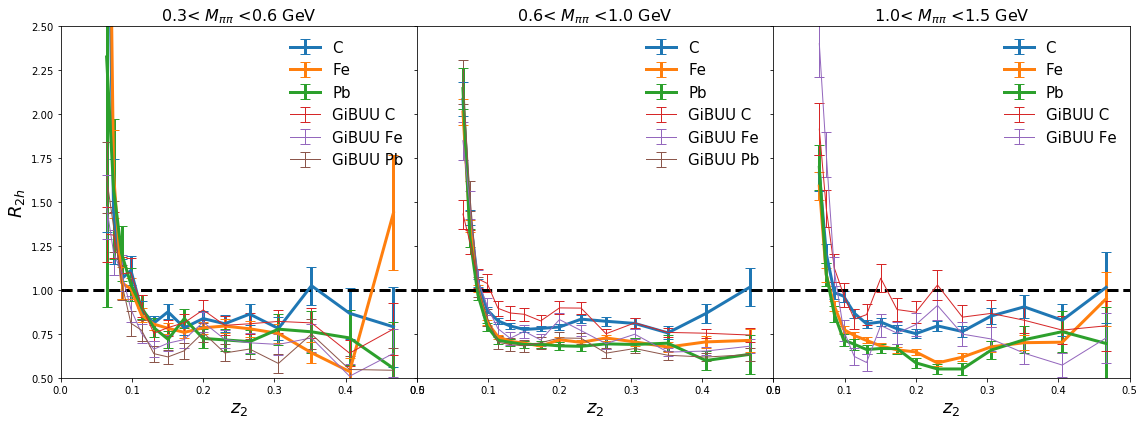

In [17]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True, figsize=(16,6), gridspec_kw={'hspace': 0, 'wspace':0})


mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['legend.fontsize']= 15

for target in ['C','Fe','Pb']:
    r, err,x   = getRatio(df[target], df['D_%s'%target], 
                          df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                          pair_cut='and mass<0.6 and mass>0.3')
    axs[0].errorbar(x,r,yerr=err,label='%s'%target)
axs[0].set_title('0.3< $M_{\pi\pi}$ <0.6 GeV',fontsize=16)
for target in ['C','Fe','Pb']:
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                 trig_cut='z>0.5', pair_cut='and mass<0.6 and mass>0.3')
    axs[0].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=0,lw=1)

axs[0].axhline(y=1.0,color='black',linestyle='--')
axs[0].legend(frameon=False)
plt.xlim([0.0,0.5])

for target in ['C','Fe','Pb']:
    r, err,x   = getRatio(df[target], df['D_%s'%target], 
                          df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                          pair_cut='and mass>0.6 and mass<1.0')
    axs[1].errorbar(x,r,yerr=err,label='%s'%target)
axs[1].set_title('0.6< $M_{\pi\pi}$ <1.0 GeV',fontsize=16)
for target in ['C','Fe','Pb']:
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                 trig_cut='z>0.5', pair_cut='and mass>0.6 and mass<1.0')
    axs[1].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=0,lw=1)

axs[1].axhline(y=1.0,color='black',linestyle='--')
axs[1].legend(frameon=False)
plt.xlim([0.0,0.5])


for target in ['C','Fe','Pb']:
    r, err,x   = getRatio(df[target], df['D_%s'%target], 
                          df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                          pair_cut='and mass>1.0 and mass<1.5')
    axs[2].errorbar(x,r,yerr=err,label='%s'%target)
axs[2].set_title('1.0< $M_{\pi\pi}$ <1.5 GeV',fontsize=16)
for target in ['C','Fe']:
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                 trig_cut='z>0.5', pair_cut='and mass>1.0 and mass<1.5')
    axs[2].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=0,lw=1)

axs[2].axhline(y=1.0,color='black',linestyle='--')
axs[2].legend(frameon=False)
plt.xlim([0.0,0.5])
plt.ylim([0.5,2.5])



axs[0].xaxis.set_label_text('$z_{2}$',fontsize=18)
axs[1].xaxis.set_label_text('$z_{2}$',fontsize=18)
axs[2].xaxis.set_label_text('$z_{2}$',fontsize=18)

axs[0].yaxis.set_label_text('$R_{2h}$',fontsize=18)

plt.tight_layout()
plt.savefig('R2h_massdependence.png')
plt.show()

## Checking R2h as a function of z_tot instead of z2

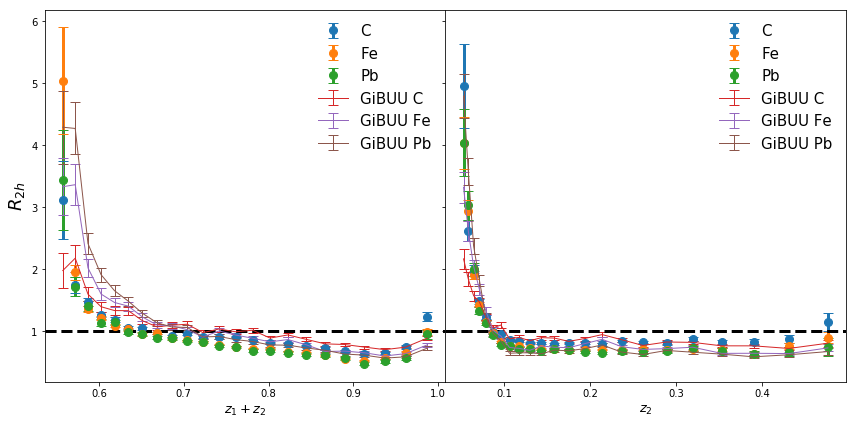

In [24]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['C','Fe','Pb']:
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,minz=0.55,maxz=1.0,variable='z_tot')
    axs[0].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,minz=0.05,maxz=.50,variable='z_asso')
    axs[1].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    
for target in ['C','Fe','Pb']:
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],nbins=24,minz=0.55,maxz=1.0,variable='z_tot')
    axs[0].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=0,lw=1)  
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],nbins=24,minz=0.05,maxz=.50,variable='z_asso')
    axs[1].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=0,lw=1)  

axs[0].legend(frameon=False)
axs[0].yaxis.set_label_text('$R_{2h}$',fontsize=18)
axs[0].xaxis.set_label_text("$z_1+z_2$", fontsize=13)

axs[0].axhline(y=1.0,color='black',linestyle='--')

axs[1].legend(frameon=False)
axs[1].xaxis.set_label_text("$z_2$", fontsize=13)

axs[1].axhline(y=1.0,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('ComparisonwithZtotal.png')
plt.show()


## Compare results with and without z_tot<0.8 cut

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


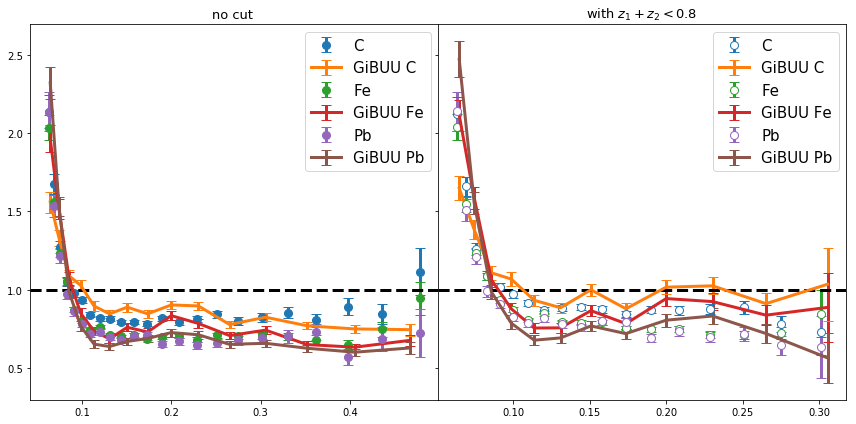

In [26]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['C','Fe','Pb']:
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,variable='z_asso')
    axs[0].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,variable='z_asso',pair_cut=' and z_tot<0.8')
    axs[1].errorbar(x,r,yerr=err,label=target,fmt='o',mfc='white',ms=8,lw=3,capsize=5)

    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                          )
    axs[0].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=3,capsize=5)
 
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                         pair_cut=' and z_tot<0.80')
    axs[1].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=3,capsize=5)
    
    
axs[1].axhline(y=1.0,color='black',linestyle='--')
axs[0].axhline(y=1.0,color='black',linestyle='--')

axs[1].set_title('with $z_1+z_2<$0.8', fontsize=13)
axs[0].set_title('no cut ', fontsize=13)

axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.savefig('ExclusiveCutVariation.png')
plt.show()

## Checking the dependency of the ratios on varios things like the charged of leading pion, subleading pion; Q2 and Nu

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


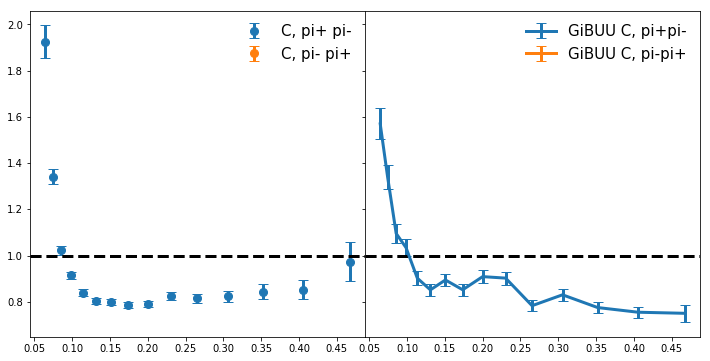

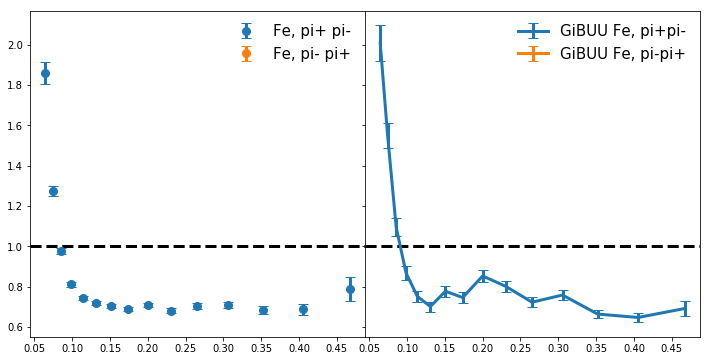

In [20]:

for target in ['C','Fe']:
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})

    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso<0')
    axs[0].errorbar(x,r,yerr=err,label='%s, pi+ pi-'%target,fmt='o',ms=8,lw=3,capsize=5)
    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='z>0.5and pid<0', pair_cut='and pid <0 and pid_asso>0')
    axs[0].errorbar(x,r,yerr=err,label='%s, pi- pi+'%target,fmt='o',ms=8,lw=3,capsize=5)

    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                          df_trigger['GiBUU_D_trigger'], 
                      trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso<0')                                              
    axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, pi+pi-'%target,ms=8,lw=3,capsize=5)


    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                          df_trigger['GiBUU_D_trigger'], 
                      trig_cut='z>0.5and pid<0', pair_cut='and pid <0 and pid_asso>0')                                      
    axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, pi-pi+'%target,ms=8,lw=3,capsize=5)

    axs[1].axhline(y=1.0,color='black',linestyle='--')
    axs[0].axhline(y=1.0,color='black',linestyle='--')

    axs[0].legend(frameon=False)
    axs[1].legend(frameon=False)


    plt.savefig('ConsistencyCharge_%s.png'%target)
    plt.show()
    plt.clf()

## Same sign results:

## z2 distribution breakdown for pi+ and pi- for all nuclei

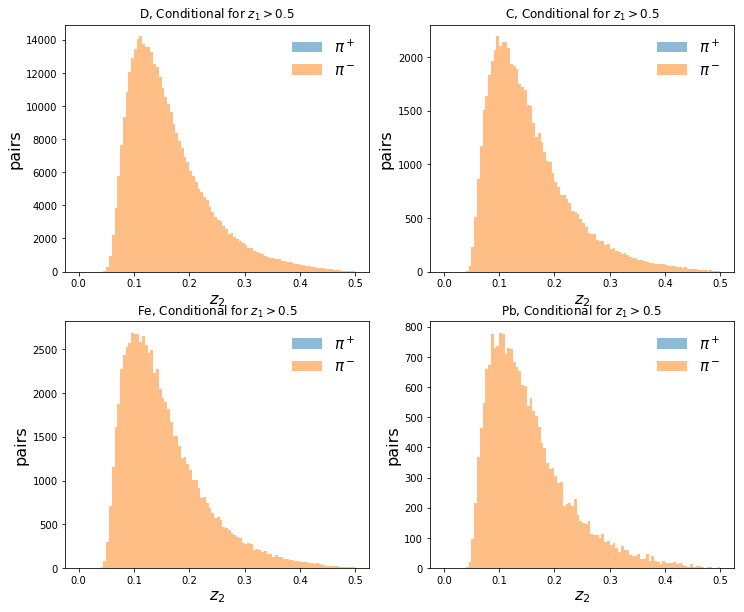

In [30]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df[target].query('z>0.5 and pid_asso>0')['z_asso'], bins=100,range =(0,0.5),label='$\pi^+$',alpha=0.5)
    plt.hist(df[target].query('z>0.5 and pid_asso<0')['z_asso'], bins=100,range =(0,0.5),label='$\pi^-$',alpha=0.5)

    plt.title('%s, Conditional for $z_{1}>0.5$'%target)
    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{2}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('ConditionalDistribution_z2_BothPions.png')

# z distribution of triggers by charge

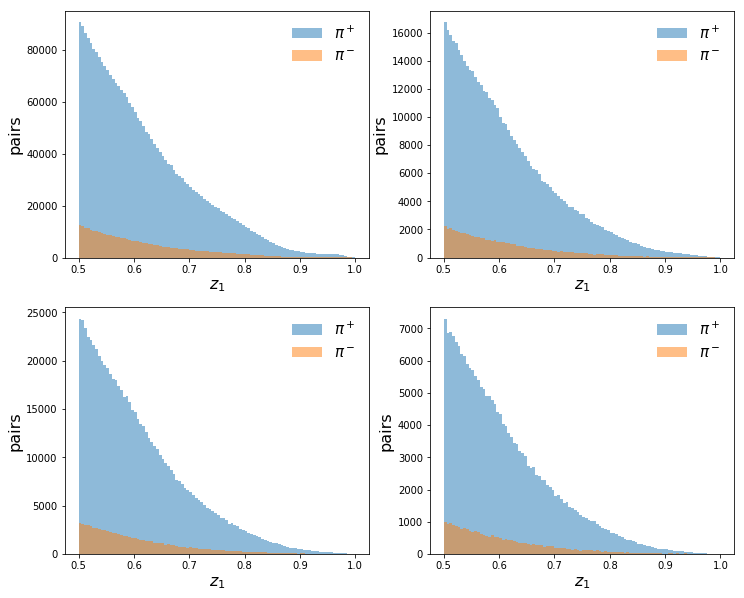

In [31]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df_trigger['%s_trigger'%target].query('z>0.5 and pid>0')['z'], bins=100,range =(0.5,1.0),label='$\pi^+$',alpha=0.5)
    plt.hist(df_trigger['%s_trigger'%target].query('z>0.5 and pid<0')['z'], bins=100,range =(0.5,1.0),label='$\pi^-$',alpha=0.5)

    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{1}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('Triggers.png')

## Distributions


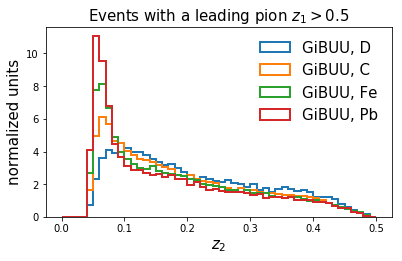

In [33]:
plt.hist(df['GiBUU_D']['z_asso'],bins=50,normed=True,range=(0.0,0.5),lw=2,label='GiBUU, D',histtype='step')
plt.hist(df['GiBUU_C']['z_asso'],bins=50,normed=True,range=(0.0,0.5),lw=2,label='GiBUU, C',histtype='step')
plt.hist(df['GiBUU_Fe']['z_asso'],bins=50,normed=True,range=(0.0,0.5),lw=2,label='GiBUU, Fe',histtype='step')
plt.hist(df['GiBUU_Pb']['z_asso'],bins=50,normed=True,range=(0.0,0.5),lw=2,label='GiBUU, Pb',histtype='step')


plt.xlabel("$z_2$", fontsize=15)
plt.ylabel("normalized units", fontsize=15)
plt.title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

#plt.axvline(x=0.06,linestyle='--',color='black')

plt.legend(frameon=False)
plt.show()

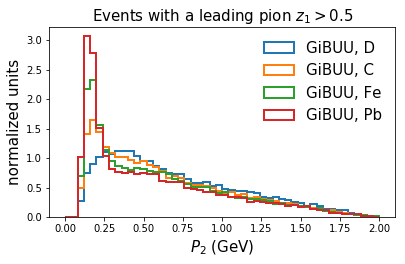

In [47]:
plt.hist(df['GiBUU_D']['P_asso'],bins=50,normed=True,range=(0.0,2.0),lw=2,label='GiBUU, D',histtype='step')
plt.hist(df['GiBUU_C']['P_asso'],bins=50,normed=True,range=(0.0,2.0),lw=2,label='GiBUU, C',histtype='step')
plt.hist(df['GiBUU_Fe']['P_asso'],bins=50,normed=True,range=(0.0,2.0),lw=2,label='GiBUU, Fe',histtype='step')
plt.hist(df['GiBUU_Pb']['P_asso'],bins=50,normed=True,range=(0.0,2.0),lw=2,label='GiBUU, Pb',histtype='step')


plt.xlabel("$P_2$ (GeV)", fontsize=15)
plt.ylabel("normalized units", fontsize=15)
plt.title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

#plt.axvline(x=0.06,linestyle='--',color='black')

plt.legend(frameon=False)
plt.show()

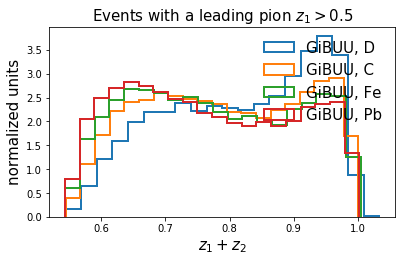

In [35]:
plt.hist(df['GiBUU_D']['z_tot'],bins=20,normed=True,label='GiBUU, D',histtype='step',lw=2)
plt.hist(df['GiBUU_C']['z_tot'],bins=20,normed=True,label='GiBUU, C',histtype='step',lw=2)
plt.hist(df['GiBUU_Fe']['z_tot'],bins=20,normed=True,label='GiBUU, Fe',histtype='step',lw=2)
plt.hist(df['GiBUU_Pb']['z_tot'],bins=20,normed=True,label='GiBUU, Pb',histtype='step',lw=2)

plt.xlabel("$z_1+z_2$", fontsize=15)
plt.ylabel("normalized units", fontsize=15)
plt.title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.legend(frameon=False)
plt.show()

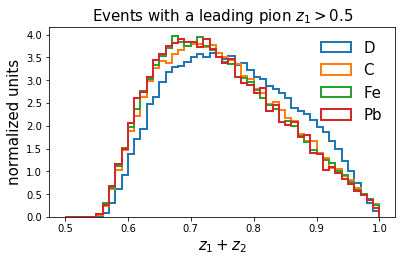

In [36]:
plt.hist(df['D_Pb']['z_tot'],bins=50,normed=True,range=(0.5,1.0),label='D',lw=2,histtype='step')
plt.hist(df['C']['z_tot'],bins=50,normed=True,range=(0.5,1.0),label='C',lw=2,histtype='step')
plt.hist(df['Fe']['z_tot'],bins=50,normed=True,range=(0.5,1.0),label='Fe',lw=2,histtype='step')
plt.hist(df['Pb']['z_tot'],bins=50,normed=True,range=(0.5,1.0),label='Pb',lw=2,histtype='step')


plt.xlabel("$z_1+z_2$", fontsize=15)
plt.ylabel("normalized units", fontsize=15)
plt.title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.legend(frameon=False)
plt.show()

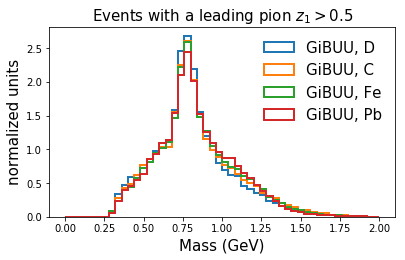

In [37]:
plt.hist(df['GiBUU_D']['mass'],bins=50,normed=True,range=(0.0,2.0),label='GiBUU, D',lw=2,histtype='step')
plt.hist(df['GiBUU_C']['mass'],bins=50,normed=True,range=(0.0,2.0),label='GiBUU, C',lw=2,histtype='step')
plt.hist(df['GiBUU_Fe']['mass'],bins=50,normed=True,range=(0.0,2.0),label='GiBUU, Fe',lw=2,histtype='step')
plt.hist(df['GiBUU_Pb']['mass'],bins=50,normed=True,range=(0.0,2.0),label='GiBUU, Pb',lw=2,histtype='step')


plt.xlabel("Mass (GeV)", fontsize=15)
plt.ylabel("normalized units", fontsize=15)
plt.title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.legend(frameon=False)
plt.show()

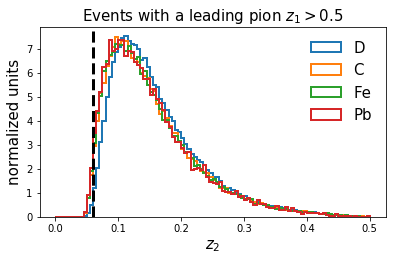

In [41]:
plt.hist(df['D_Pb']['z_asso'],bins=100,normed=True,range=(0.0,0.5),label='D',lw=2,histtype='step')
plt.hist(df['C']['z_asso'],bins=100,normed=True,range=(0.0,0.5),label='C',lw=2,histtype='step')
plt.hist(df['Fe']['z_asso'],bins=100,normed=True,range=(0.0,0.5),label='Fe',lw=2,histtype='step')
plt.hist(df['Pb']['z_asso'],bins=100,normed=True,range=(0.0,0.5),label='Pb',lw=2,histtype='step')


plt.xlabel("$z_2$", fontsize=15)
plt.ylabel("normalized units", fontsize=15)
plt.title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
plt.axvline(x=0.06,linestyle='--',color='black')

plt.legend(frameon=False)
plt.show()

In [42]:
## P_asso for data

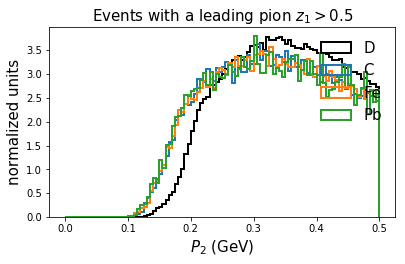

In [43]:
plt.hist(df['D']['P_asso'],bins=100,normed=True,range=(0.0,0.5),color='black',label='D',lw=2,histtype='step')
plt.hist(df['C']['P_asso'],bins=100,normed=True,range=(0.0,.50),label='C',lw=2,histtype='step')
plt.hist(df['Fe']['P_asso'],bins=100,normed=True,range=(0.0,.50),label='Fe',lw=2,histtype='step')
plt.hist(df['Pb']['P_asso'],bins=100,normed=True,range=(0.0,.50),label='Pb',lw=2,histtype='step')


plt.xlabel("$P_2$ (GeV)", fontsize=15)
plt.ylabel("normalized units", fontsize=15)
plt.title('Events with a leading pion $z_{1}>0.5$',fontsize=15)


plt.legend(frameon=False)
plt.show()

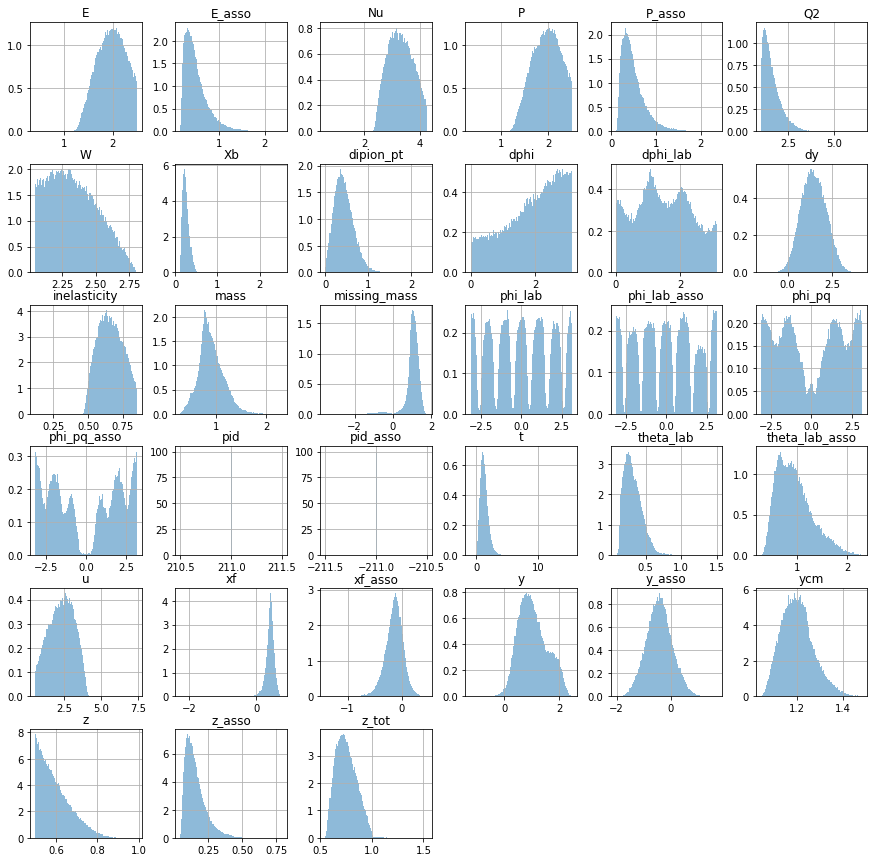

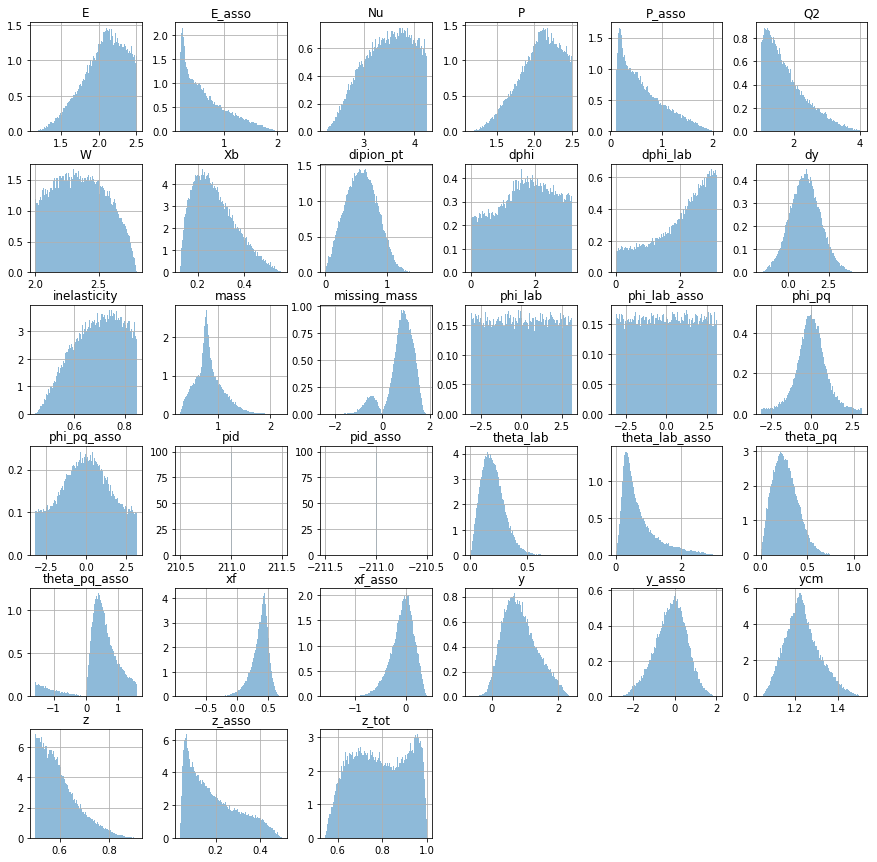

In [44]:
df['C'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=100)
df['GiBUU_C'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=100)

plt.show()

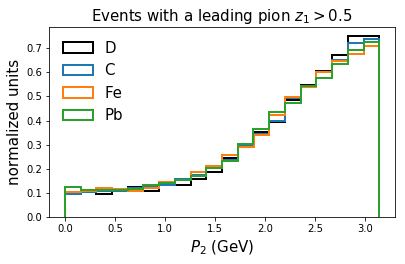

In [48]:
plt.hist(df['GiBUU_D'].query('z_asso>0.1')['dphi_lab'],bins=20,normed=True,color='black',label='D',lw=2,histtype='step')
plt.hist(df['GiBUU_C'].query('z_asso>0.1')['dphi_lab'],bins=20,normed=True,label='C',lw=2,histtype='step')
plt.hist(df['GiBUU_Fe'].query('z_asso>0.1')['dphi_lab'],bins=20,normed=True,label='Fe',lw=2,histtype='step')
plt.hist(df['GiBUU_Pb'].query('z_asso>0.1')['dphi_lab'],bins=20,normed=True,label='Pb',lw=2,histtype='step')


plt.xlabel("$P_2$ (GeV)", fontsize=15)
plt.ylabel("normalized units", fontsize=15)
plt.title('Events with a leading pion $z_{1}>0.5$',fontsize=15)


plt.legend(frameon=False,loc='upper left')
plt.show()

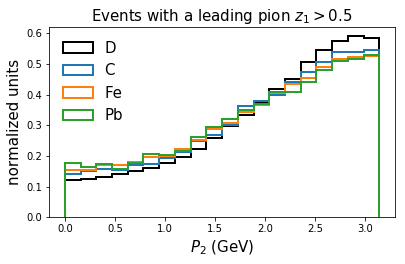

In [49]:
plt.hist(df['D'].query('z_asso>0.1')['dphi'],bins=20,normed=True,color='black',label='D',lw=2,histtype='step')
plt.hist(df['C'].query('z_asso>0.1')['dphi'],bins=20,normed=True,label='C',lw=2,histtype='step')
plt.hist(df['Fe'].query('z_asso>0.1')['dphi'],bins=20,normed=True,label='Fe',lw=2,histtype='step')
plt.hist(df['Pb'].query('z_asso>0.1')['dphi'],bins=20,normed=True,label='Pb',lw=2,histtype='step')


plt.xlabel("$P_2$ (GeV)", fontsize=15)
plt.ylabel("normalized units", fontsize=15)
plt.title('Events with a leading pion $z_{1}>0.5$',fontsize=15)


plt.legend(frameon=False,loc='upper left')
plt.show()